In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import bout.clustering as clstr
import bout.assembly as bt
import bout.plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)
        
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

In [25]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[0])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 780
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [26]:
location_df

,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,LF,0,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.353200000,1380.3355,1380.3532,28046.0,31703.0,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
1,LF,1,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.612900000,1513.5975,1513.6129,23750.0,28075.0,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
2,LF,2,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.839600000,1513.8235,1513.8396,23750.0,28002.0,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
3,LF,3,2022-07-13 04:55:13.988500000,2022-07-13 04:55:13.988500000,2022-07-13 04:55:14.001000000,1513.9885,1514.0010,24609.0,30884.0,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
4,LF,4,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.283900000,1514.2675,1514.2839,23750.0,28526.0,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016308,LF,49,2022-10-17 07:56:42.025500000,2022-10-17 07:56:42.025500000,2022-10-17 07:56:42.039100000,1602.0255,1602.0391,25468.0,30005.0,Echolocation,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016309,LF,50,2022-10-17 07:56:42.396500000,2022-10-17 07:56:42.396500000,2022-10-17 07:56:42.410600000,1602.3965,1602.4106,25468.0,28304.0,Echolocation,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016310,LF,0,2022-10-17 09:20:50.849500000,2022-10-17 09:20:50.849500000,2022-10-17 09:20:50.857300000,1250.8495,1250.8573,44375.0,52935.0,Echolocation,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016311,LF,1,2022-10-17 09:20:51.841500000,2022-10-17 09:20:51.841500000,2022-10-17 09:20:51.852100000,1251.8415,1251.8521,42656.0,60216.0,Echolocation,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN


In [7]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)

In [8]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

In [23]:
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__HFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_HFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_HFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_HFCarp_summary',
 'dc_callrate_TYPE_SITE_summary': 'dc_callrate_HFCarp_summary',
 'cont_callrate_TYPE_SITE_summary': 'cont_callrate_HFCarp_summary',
 'dc_btp_TYPE_SITE_summary': 'dc_btp_HFCarp_summary',
 'cont_btp_TYPE_SITE_summary': 'cont_btp_HFCarp_summary',

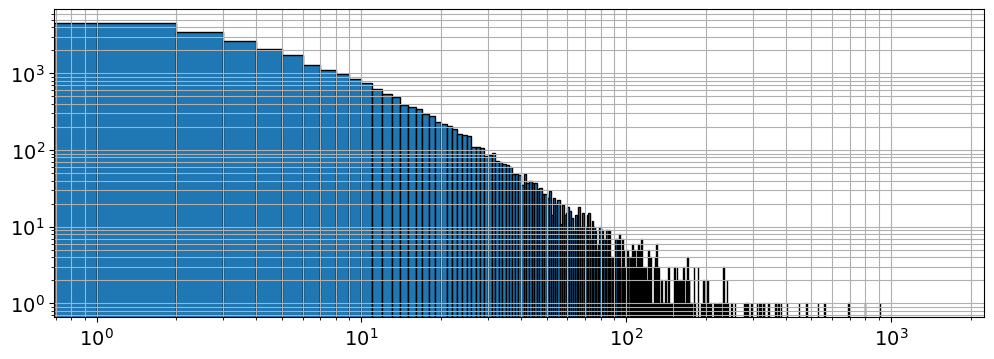

In [9]:
bout_durations_raw = bout_metrics['bout_duration_in_secs'].values
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':14})
plt.hist(bout_durations_raw, bins=np.arange(0, bout_durations_raw.max(), 1), edgecolor='k')
plt.grid(which='both')
plt.yscale('log')
plt.xscale('log')

In [10]:
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,7,27,8,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,7,27,8,30,0))]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

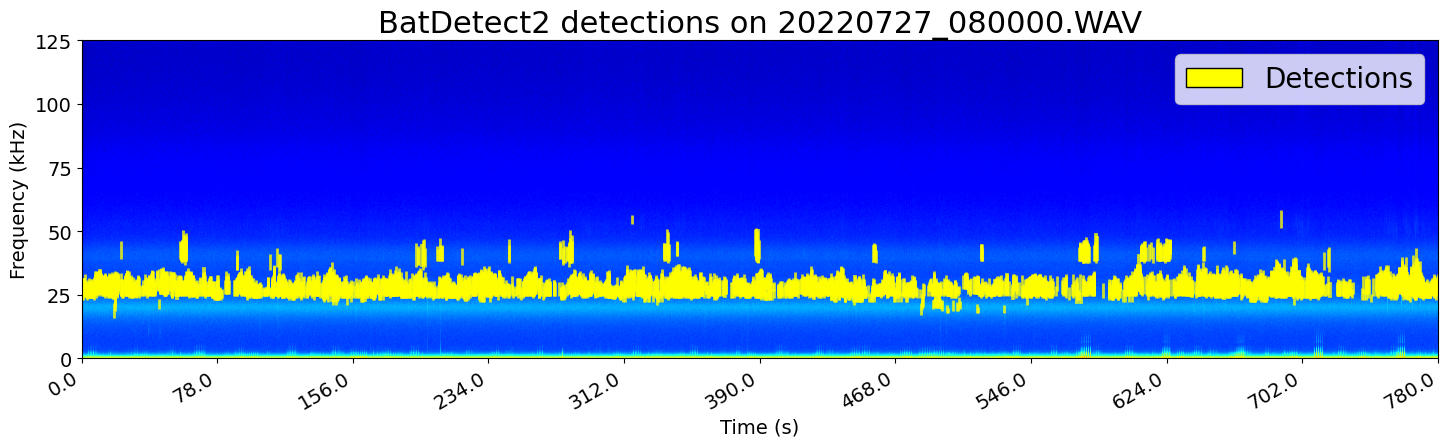

In [11]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)

In [12]:
plot_bouts = bout_metrics.loc[(bout_metrics['start_time_of_bout']>=dt.datetime(2022,7,27,8,0,0))&(bout_metrics['end_time_of_bout']<=dt.datetime(2022,7,27,8,30,0))]
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]

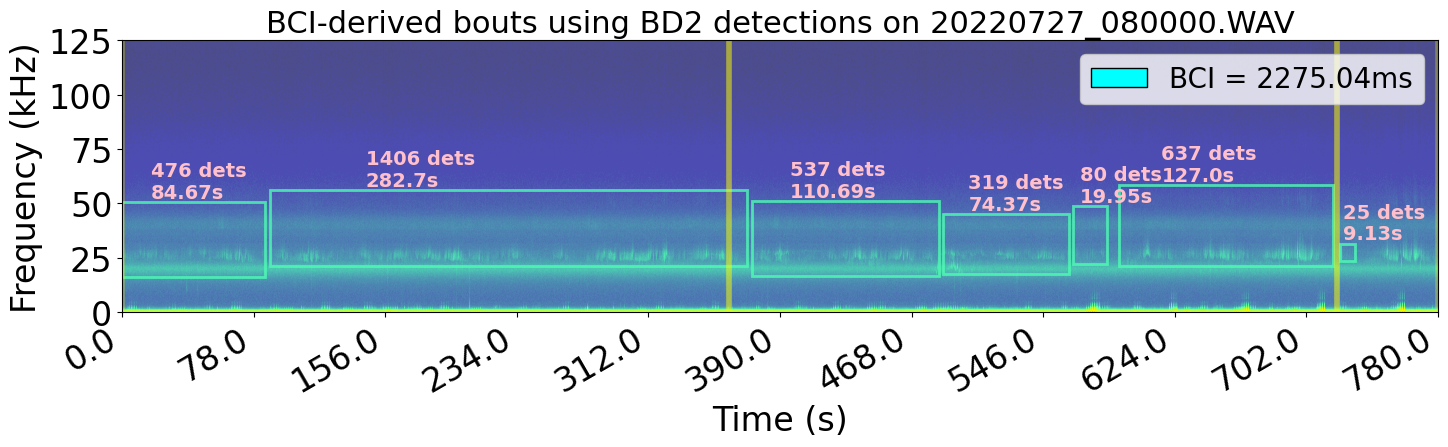

In [13]:
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [27]:
site_key = 'Carp'
freq_key = 'HF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[0])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 49
duration = 1
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 40 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [28]:
location_df

,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
74,HF,31,2022-07-13 05:06:41.952500000,2022-07-13 05:06:41.952500000,2022-07-13 05:06:41.959300000,401.9525,401.9593,41796.0,48768.0,Echolocation,Pipistrellus nathusii,0.438,0.557,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
75,HF,32,2022-07-13 05:06:42.639500000,2022-07-13 05:06:42.639500000,2022-07-13 05:06:42.650500000,402.6395,402.6505,41796.0,48011.0,Echolocation,Pipistrellus nathusii,0.533,0.603,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
76,HF,33,2022-07-13 05:06:42.734500000,2022-07-13 05:06:42.734500000,2022-07-13 05:06:42.744100000,402.7345,402.7441,40937.0,47802.0,Echolocation,Pipistrellus nathusii,0.550,0.638,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
77,HF,34,2022-07-13 05:06:42.828500000,2022-07-13 05:06:42.828500000,2022-07-13 05:06:42.836000000,402.8285,402.8360,40937.0,52437.0,Echolocation,Pipistrellus nathusii,0.548,0.607,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
78,HF,35,2022-07-13 05:06:42.934500000,2022-07-13 05:06:42.934500000,2022-07-13 05:06:42.941700000,402.9345,402.9417,41796.0,51559.0,Echolocation,Pipistrellus nathusii,0.611,0.648,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016255,HF,33,2022-10-17 06:58:09.073500000,2022-10-17 06:58:09.073500000,2022-10-17 06:58:09.080500000,1689.0735,1689.0805,46953.0,63167.0,Echolocation,Pipistrellus pipistrellus,0.524,0.601,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016256,HF,34,2022-10-17 06:58:09.147500000,2022-10-17 06:58:09.147500000,2022-10-17 06:58:09.155300000,1689.1475,1689.1553,47812.0,61684.0,Echolocation,Pipistrellus pipistrellus,0.509,0.535,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016257,HF,35,2022-10-17 06:58:09.232500000,2022-10-17 06:58:09.232500000,2022-10-17 06:58:09.239400000,1689.2325,1689.2394,47812.0,61308.0,Echolocation,Pipistrellus pipistrellus,0.561,0.592,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016258,HF,36,2022-10-17 06:58:09.602500000,2022-10-17 06:58:09.602500000,2022-10-17 06:58:09.610200000,1689.6025,1689.6102,46953.0,60179.0,Echolocation,Pipistrellus pipistrellus,0.465,0.575,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN


In [15]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)

In [16]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

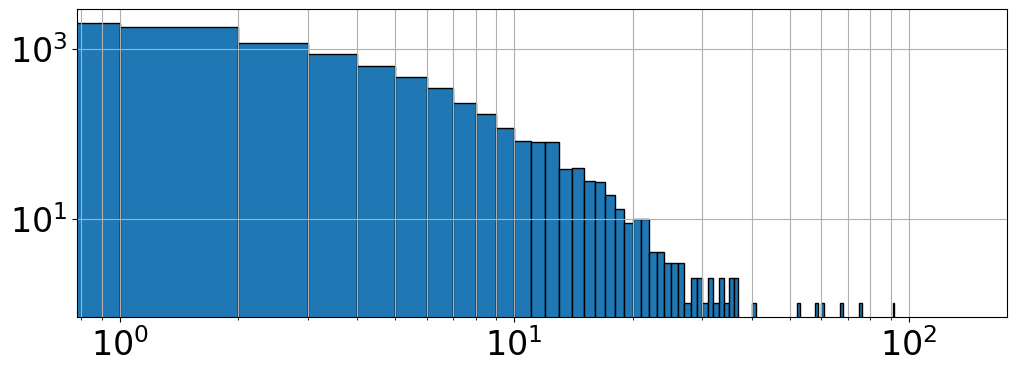

In [17]:
bout_durations_raw = bout_metrics['bout_duration_in_secs'].values
plt.figure(figsize=(12,4))
plt.hist(bout_durations_raw, bins=np.arange(0, bout_durations_raw.max(), 1), edgecolor='k')
plt.grid(which='both')
plt.yscale('log')
plt.xscale('log')

In [18]:
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=dt.datetime(2022,7,27,8,0,0))&(dc_applied_df['call_end_time']<=dt.datetime(2022,7,27,8,30,0))]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]

## These are not HF

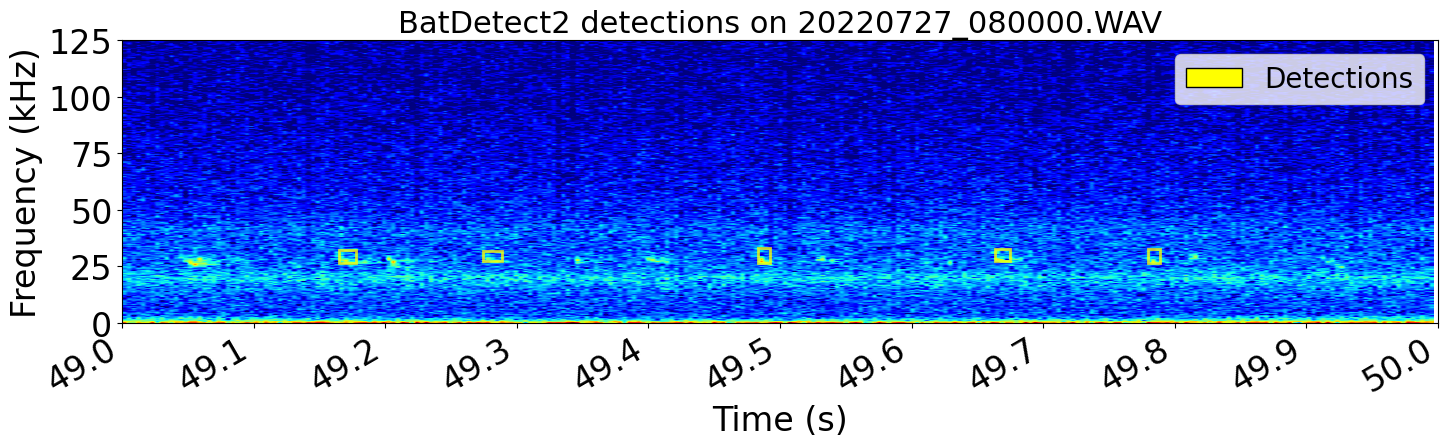

In [19]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)

In [20]:
plot_dets.iloc[:,2:14]

,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob
216374,HF,303,2022-07-27 08:00:49.164500,2022-07-27 08:00:49.164500,2022-07-27 08:00:49.177800,49.1645,49.1778,26328.0,32032.0,Echolocation,Nyctalus leisleri,0.392
216376,HF,305,2022-07-27 08:00:49.274500,2022-07-27 08:00:49.274500,2022-07-27 08:00:49.288700,49.2745,49.2887,27187.0,31631.0,Echolocation,Nyctalus leisleri,0.467
216379,HF,308,2022-07-27 08:00:49.483500,2022-07-27 08:00:49.483500,2022-07-27 08:00:49.492700,49.4835,49.4927,26328.0,33182.0,Echolocation,Nyctalus leisleri,0.648
216381,HF,310,2022-07-27 08:00:49.663500,2022-07-27 08:00:49.663500,2022-07-27 08:00:49.674700,49.6635,49.6747,27187.0,32881.0,Echolocation,Nyctalus leisleri,0.493
216382,HF,311,2022-07-27 08:00:49.779500,2022-07-27 08:00:49.779500,2022-07-27 08:00:49.789100,49.7795,49.7891,26328.0,32588.0,Echolocation,Nyctalus leisleri,0.582


In [21]:
plot_bouts = bout_metrics.loc[(bout_metrics['start_time_of_bout']>=dt.datetime(2022,7,27,8,0,0))&(bout_metrics['end_time_of_bout']<=dt.datetime(2022,7,27,8,30,0))]
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]

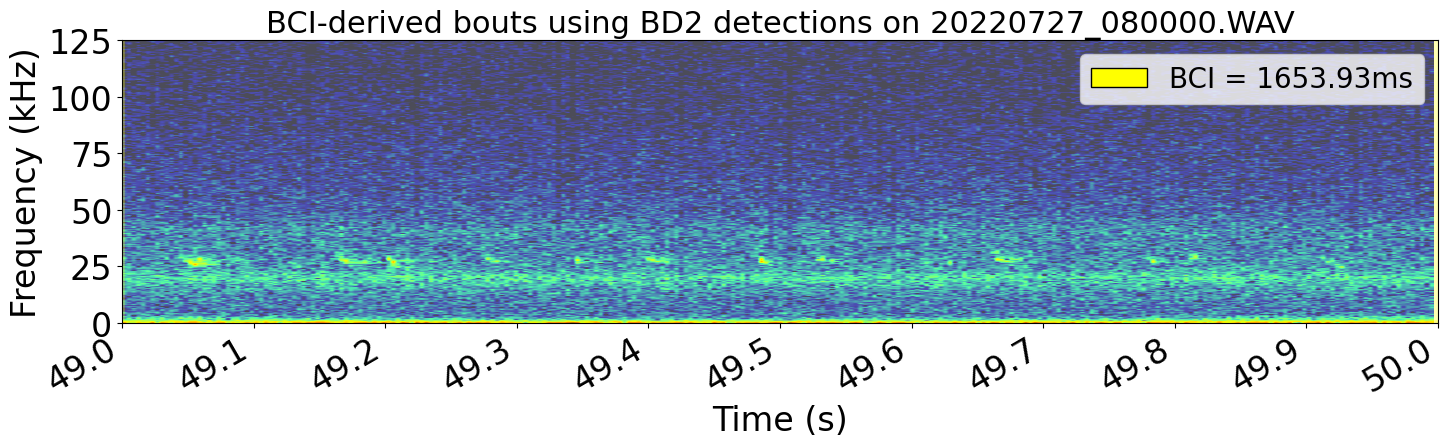

In [22]:
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)